## Import Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm
from catboost import CatBoostClassifier
from sortedcontainers import SortedList
import copy
import collections
from itertools import product,chain
from sklearn.model_selection import KFold
import catboost as cb
from numpy import loadtxt
from sklearn.model_selection import StratifiedKFold, GroupKFold
from lightgbm import LGBMClassifier
#hyperparameter optimization
from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin
from functools import partial
import seaborn as sns

## Load dataset

In [2]:
train=pd.read_csv(r'/home/ssamine/wids/training_v2.csv')
test=pd.read_csv(r'/home/ssamine/wids/unlabeled.csv')
final_cp=pd.read_csv(r'/home/ssamine/wids/unlabeled.csv')

## Feature Engineering

In [3]:
train.drop("readmission_status",inplace=True,axis=1)
test.drop("readmission_status",inplace=True,axis=1)

In [4]:
test.drop("hospital_death",inplace=True,axis=1)
y_train = train[['encounter_id', 'patient_id', 'hospital_id',"hospital_death"]].copy()
train.drop("hospital_death",inplace=True,axis=1)

In [5]:
combined_dataset = pd.concat(objs = [train, test], axis = 0)
df_cat = combined_dataset.select_dtypes(include=['object', 'category'])

In [6]:
combined_dataset['hospital_admit_source'] = combined_dataset['hospital_admit_source'].replace({'Other ICU': 'ICU','ICU to SDU':'SDU', 'Step-Down Unit (SDU)': 'SDU',
                                                                                               'Other Hospital':'Other','Observation': 'Recovery Room','Acute Care/Floor': 'Acute Care'})

combined_dataset['icu_type'] = combined_dataset['icu_type'].replace({'CCU-CTICU': 'Grpd_CICU', 'CTICU':'Grpd_CICU', 'Cardiac ICU':'Grpd_CICU'})

combined_dataset['apache_2_bodysystem'] = combined_dataset['apache_2_bodysystem'].replace({'Undefined diagnoses': 'Undefined Diagnoses'})


In [7]:
# Dropping 'patient_id', 'hospital_id', 'gender'
combined_dataset = combined_dataset.drop(['patient_id','hospital_id', 'gender'], axis=1)

In [8]:
train_len = len(train)

In [9]:
import copy
train_new = copy.copy(combined_dataset[:train_len])
test_new = copy.copy(combined_dataset[train_len:])

# Impute Missing Values

In [10]:
from fancyimpute import IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on diabetes
train_new[['age', 'height', 'weight', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']] = mice_imputer.fit_transform(train[['age', 'height', 'weight','apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']])
test_new[['age', 'height', 'weight', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']] = mice_imputer.fit_transform(test[['age', 'height', 'weight', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']])

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
col_train = train_new.columns
col_test = test_new.columns

In [12]:
l1 = []
l2 = []
for i in col_train:
    if train_new[i].nunique() <= 0:
        l1.append(i)


for i in col_test:
    if test_new[i].nunique() <= 0:
        l2.append(i)


In [13]:
train_new[l1] = train_new[l1].apply(lambda x: x.astype('category'), axis=0)
test_new[l2] = test_new[l2].apply(lambda x: x.astype('category'), axis=0)

In [14]:
categorical=train_new.select_dtypes(include='O').columns.values.tolist()

### Label encoding

In [15]:
for usecol in categorical:
    train_new[usecol] = train_new[usecol].astype('str')
    test_new[usecol] = test_new[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train_new[usecol].unique().tolist()+ test_new[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train_new[usecol] = le.transform(train_new[usecol])+1
    test_new[usecol]  = le.transform(test_new[usecol])+1
    
    train_new[usecol] = train_new[usecol].replace(np.nan, '').astype('int').astype('category')
    test_new[usecol]  = test_new[usecol].replace(np.nan, '').astype('int').astype('category')

In [16]:
train_columns2 =train_new.columns.tolist()
categorical_index = [train_columns2.index(x) for x in categorical]

In [17]:
non = ['encounter_id','icu_id']

### Check and remove correlated variables

In [18]:
correlated_features = set()
train1 = train_new.drop(non,axis=1) 
correlation_matrix = train1.corr()
del train1

In [19]:
for i in range(len(correlation_matrix.columns)):
     for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) ==  1:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
correlated_features=list(correlated_features)

In [20]:
train_new.drop(correlated_features,axis=1,inplace=True)
test_new.drop(correlated_features,axis=1,inplace=True)


In [21]:
train_new = train_new.set_index("encounter_id")
test_new = test_new.set_index("encounter_id")
y_train = y_train.set_index("encounter_id")

In [22]:
features=[col for col in train_new.columns if col not in non ]

In [23]:
y=y_train[['hospital_death']]

In [41]:
from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin
from functools import partial
from bayes_opt import BayesianOptimization
import eli5
import shap

In [60]:
if 0:    
    def objective(space):
        params = {
            'max_features': space['max_features'],
            'num_leaves':int(space['num_leaves']),
            'reg_lambda':space['reg_lambda'],
            'lambda_l1':space['lambda_l1'],
            'lambda_l2':space['lambda_l2'],
            'max_depth':int(space['max_depth']),
            'scale_pos_weight':space['scale_pos_weight']
        }
        clf = lightgbm.LGBMClassifier(n_estimators = 500,n_jobs=-1,categoricals=categorical,
                                is_unbalanced=False, **params)
        clf.fit(train_new, y.values.ravel())
        test_labels_x = clf.predict_proba(test_new)
        try:
            score = roc_auc_score(y_test, test_labels_x[:,1])
        except:
            score = 0.1
        print("PARAMS",params,"SCORE:", score)
        return score


    space ={
            'max_features':  hp.choice('max_features',['sqrt','log2', 0.5,0.75]), 
            'num_leaves': hp.quniform('num_leaves',30, 50,10), 
            'reg_lambda': hp.quniform('reg_lambda',3, 4,0.3),
            'lambda_l1':hp.quniform('lambda_l1',0,5,1),
            'lambda_l2':hp.quniform('lambda_l2',0,5,1),
            'max_depth':hp.quniform('max_depth',13,17,1),
            'scale_pos_weight':hp.quniform('scale_pos_weight',1,10,1)
        }


    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials)
#######if you want to do bayesian optimization##########
# LGB_BO = BayesianOptimization(objective, space, random_state=1029)
# import warnings
# init_points = 16
# n_iter = 16
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')    
#     LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

## Light GBM Model

In [59]:
drop_cols = ['icu_id']

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=420)
roc_auc = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = train_new.columns
pred_on_test = np.zeros(test_new.shape[0])
param = {'task': 'train',
         'boosting': 'gbdt',
         'objective':'binary',
         'metric': 'auc',
         'num_leaves': 15,
         'min_data_in_leaf': 90,
         'learning_rate': 0.01,
         'max_depth': 5,
         'scale_pos_weight' : 1,
         'feature_fraction': 0.1,
         'bagging_freq': 1,
         'bagging_fraction': 0.75,
         'use_missing': True,
         'nthread': 4
        }

for index, (train_index, valid_index) in enumerate(kf.split(X=train_new,y=y)):
    print(f"FOLD {index+1}")
    num_round = 7000
    X_train_fold, y_train_fold = train_new.iloc[train_index], y.iloc[train_index]
    X_valid_fold, y_valid_fold = train_new.iloc[valid_index], y.iloc[valid_index]

    dtrain = lightgbm.Dataset(X_train_fold, label=y_train_fold)
    dvalid = lightgbm.Dataset(X_valid_fold, label=y_valid_fold,reference=dtrain)

    lgb = lightgbm.train(param,dtrain,num_round,valid_sets=dvalid,early_stopping_rounds=100,
                         verbose_eval=200,categorical_feature=categorical_index)

    feature_importances[f'fold_{index + 1}'] = lgb.feature_importance()

    y_valid_pred = (lgb.predict(X_valid_fold,num_iteration=lgb.best_iteration))
    pred_on_test += (lgb.predict(test_new,num_iteration=lgb.best_iteration)) / kf.n_splits

    # winsorization
    y_valid_pred = np.clip(a=y_valid_pred, a_min=0, a_max=1)
    pred_on_test = np.clip(a=pred_on_test, a_min=0, a_max=1)

    print(f"FOLD {index+1}: ROC_AUC  => {np.round(roc_auc_score(y_true=y_valid_fold, y_score=y_valid_pred),5)}")
    roc_auc.append(roc_auc_score(y_true=y_valid_fold, y_score=y_valid_pred)/kf.n_splits)
    
print(f"Mean roc_auc for {kf.n_splits} folds: {np.round(sum(roc_auc),5)}")


FOLD 1


categorical_feature in Dataset is overridden.
New categorical_feature is [4, 6, 7, 9, 10, 179, 180]


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.892631
[400]	valid_0's auc: 0.899968
[600]	valid_0's auc: 0.90418
[800]	valid_0's auc: 0.906751
[1000]	valid_0's auc: 0.908541
[1200]	valid_0's auc: 0.909479
[1400]	valid_0's auc: 0.910383
[1600]	valid_0's auc: 0.910935
[1800]	valid_0's auc: 0.911211
[2000]	valid_0's auc: 0.911434
[2200]	valid_0's auc: 0.911603
[2400]	valid_0's auc: 0.911788
[2600]	valid_0's auc: 0.911948
Early stopping, best iteration is:
[2650]	valid_0's auc: 0.911994
FOLD 1: ROC_AUC  => 0.91199
FOLD 2


categorical_feature in Dataset is overridden.
New categorical_feature is [4, 6, 7, 9, 10, 179, 180]


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.883838
[400]	valid_0's auc: 0.890934
[600]	valid_0's auc: 0.894967
[800]	valid_0's auc: 0.897234
[1000]	valid_0's auc: 0.898808
[1200]	valid_0's auc: 0.89985
[1400]	valid_0's auc: 0.900508
[1600]	valid_0's auc: 0.901115
[1800]	valid_0's auc: 0.901389
[2000]	valid_0's auc: 0.901633
[2200]	valid_0's auc: 0.901926
[2400]	valid_0's auc: 0.902087
[2600]	valid_0's auc: 0.902212
[2800]	valid_0's auc: 0.902368
[3000]	valid_0's auc: 0.902325
Early stopping, best iteration is:
[2907]	valid_0's auc: 0.902408
FOLD 2: ROC_AUC  => 0.90241
FOLD 3


categorical_feature in Dataset is overridden.
New categorical_feature is [4, 6, 7, 9, 10, 179, 180]


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.889369
[400]	valid_0's auc: 0.895839
[600]	valid_0's auc: 0.899608
[800]	valid_0's auc: 0.90164
[1000]	valid_0's auc: 0.90317
[1200]	valid_0's auc: 0.904077
[1400]	valid_0's auc: 0.904676
[1600]	valid_0's auc: 0.905179
[1800]	valid_0's auc: 0.905462
[2000]	valid_0's auc: 0.905705
[2200]	valid_0's auc: 0.905981
[2400]	valid_0's auc: 0.906139
[2600]	valid_0's auc: 0.906293
Early stopping, best iteration is:
[2544]	valid_0's auc: 0.906308
FOLD 3: ROC_AUC  => 0.90631
FOLD 4


categorical_feature in Dataset is overridden.
New categorical_feature is [4, 6, 7, 9, 10, 179, 180]


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.88728
[400]	valid_0's auc: 0.894046
[600]	valid_0's auc: 0.898167
[800]	valid_0's auc: 0.900754
[1000]	valid_0's auc: 0.902367
[1200]	valid_0's auc: 0.90338
[1400]	valid_0's auc: 0.904158
[1600]	valid_0's auc: 0.904653
[1800]	valid_0's auc: 0.904902
[2000]	valid_0's auc: 0.905028
[2200]	valid_0's auc: 0.905207
[2400]	valid_0's auc: 0.905344
[2600]	valid_0's auc: 0.905486
[2800]	valid_0's auc: 0.905533
[3000]	valid_0's auc: 0.905621
Early stopping, best iteration is:
[2964]	valid_0's auc: 0.905665
FOLD 4: ROC_AUC  => 0.90567
Mean roc_auc for 4 folds: 0.90659


## Plot feature importance

In [61]:
features=train_new.columns

In [62]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb.feature_importance(importance_type='gain')
imp_df['split'] = lgb.feature_importance(importance_type='split')

In [63]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

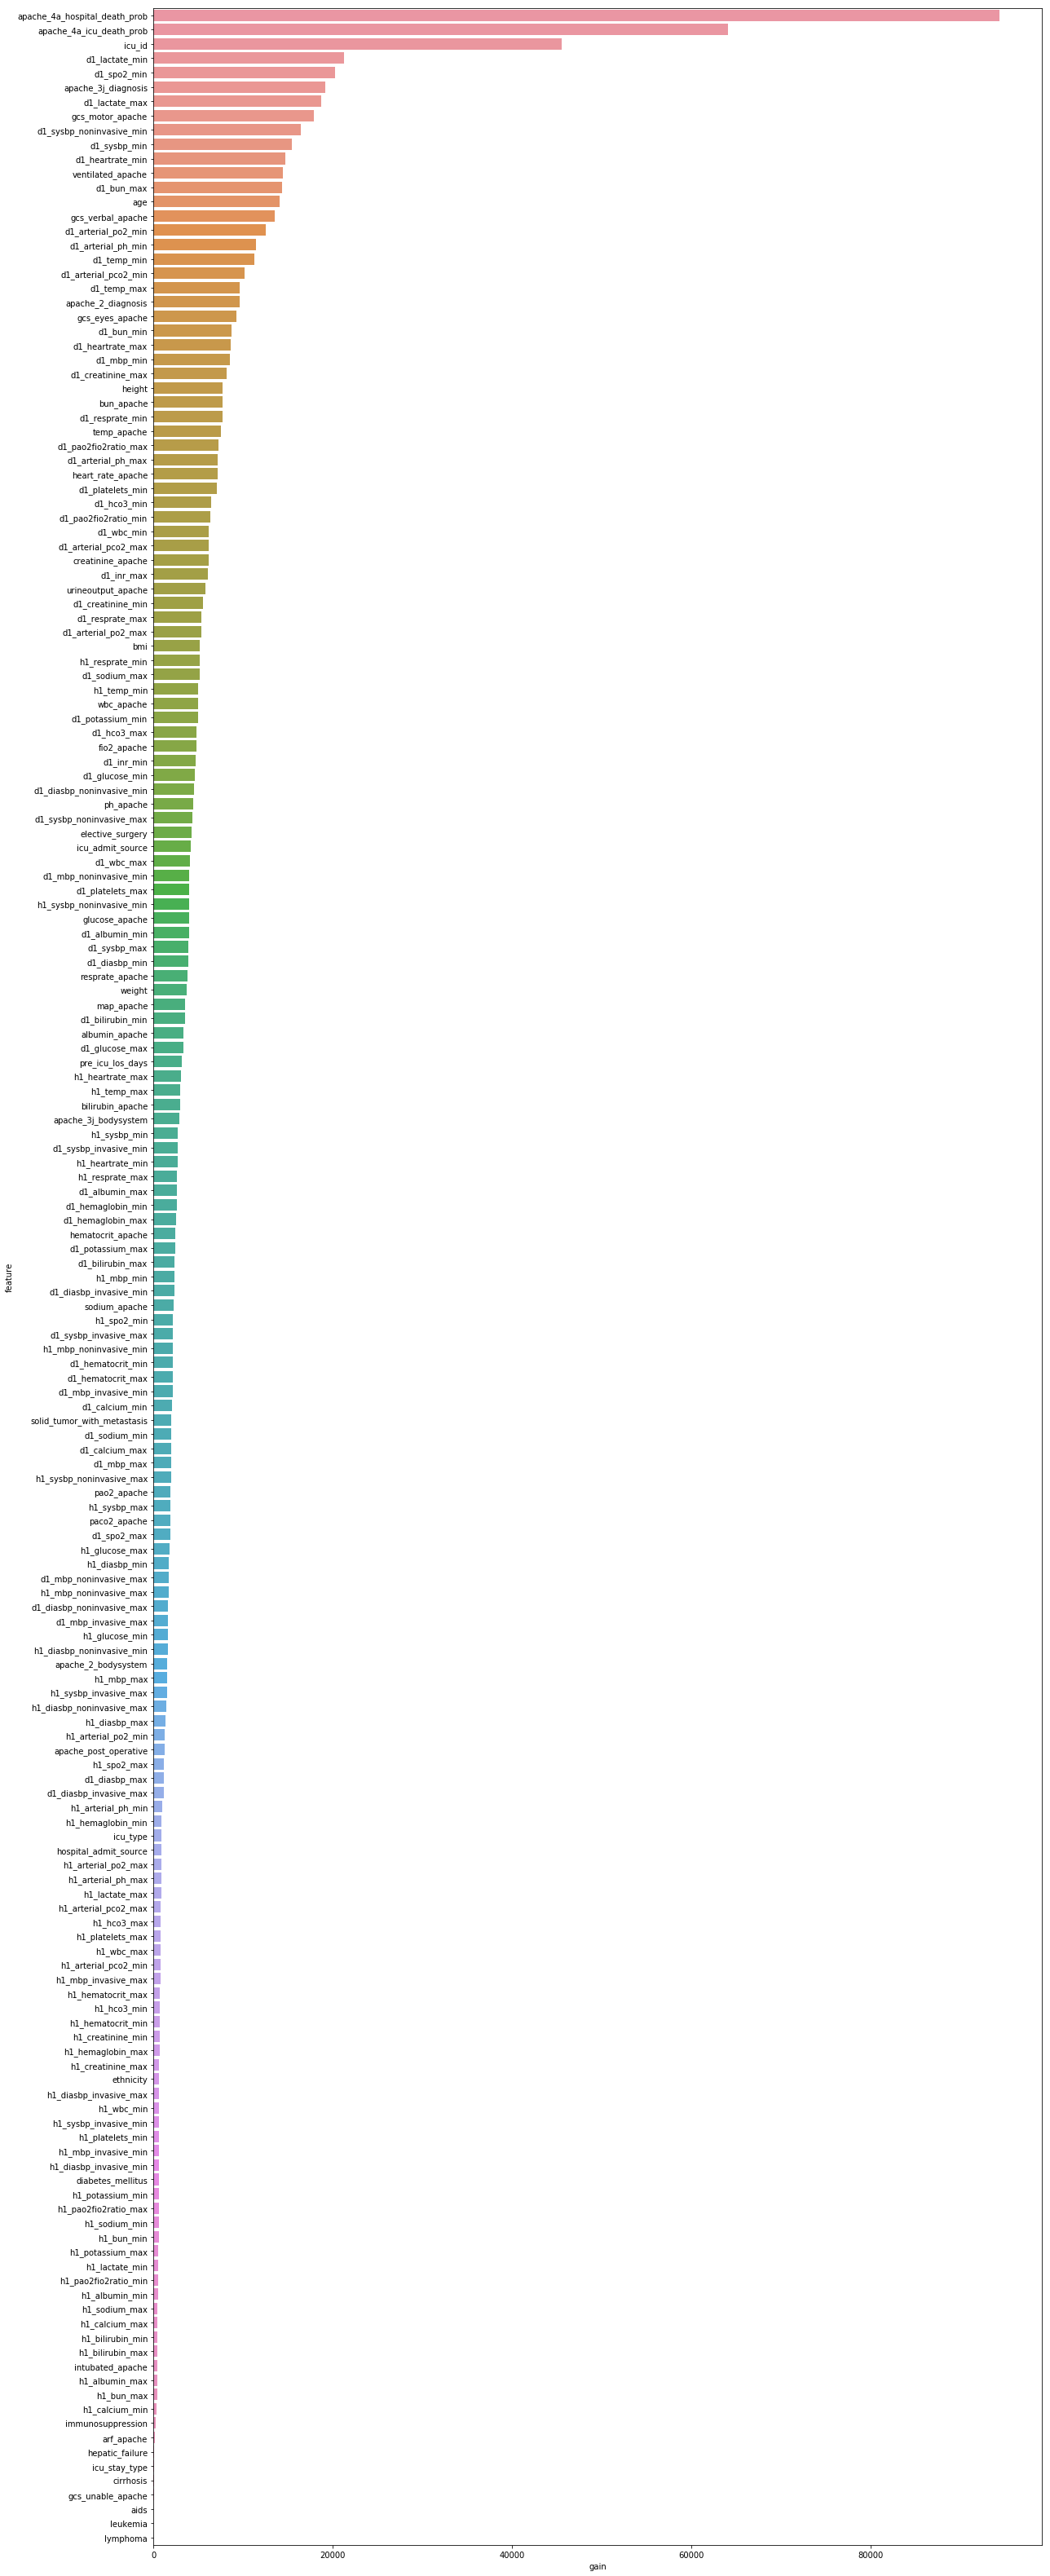

In [64]:
plot_importances(imp_df)

## Adversarial Validation

In [74]:
def adversarial_validation(train, test, features):
    
    tr_data   = train.copy()
    tst_data = test.copy()
    tr_data['target']  = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data, tst_data], axis = 0)
    av_data.reset_index(drop = True)        
    params = {
            'learning_rate': 0.1, 
            'seed': 24,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, av_data[target])) :
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[features].iloc[tr_ind], av_data[features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lightgbm.Dataset(x_train, y_train)
        val_set   = lightgbm.Dataset(x_val, y_val)
        
        model = lightgbm.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 20, valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = features
        fold_importance['gain'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', roc_auc_score(av_data[target], oof_pred))
    return important_features

In [75]:
adversarial_features = adversarial_validation(train_new, test_new, features)

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.999847	valid_1's auc: 0.999719
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	training's auc: 0.999989	valid_1's auc: 0.999695
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.999937	valid_1's auc: 0.999714
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.999917	valid_1's auc: 0.999716
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.99981	valid_1's auc: 0.999693
Our mean train roc auc score is : 0.999900068879328
Our oof roc auc score is : 0.9968913176827988


#### AUC is almost perfect so we can expect that some feature are perfectly different between train / test

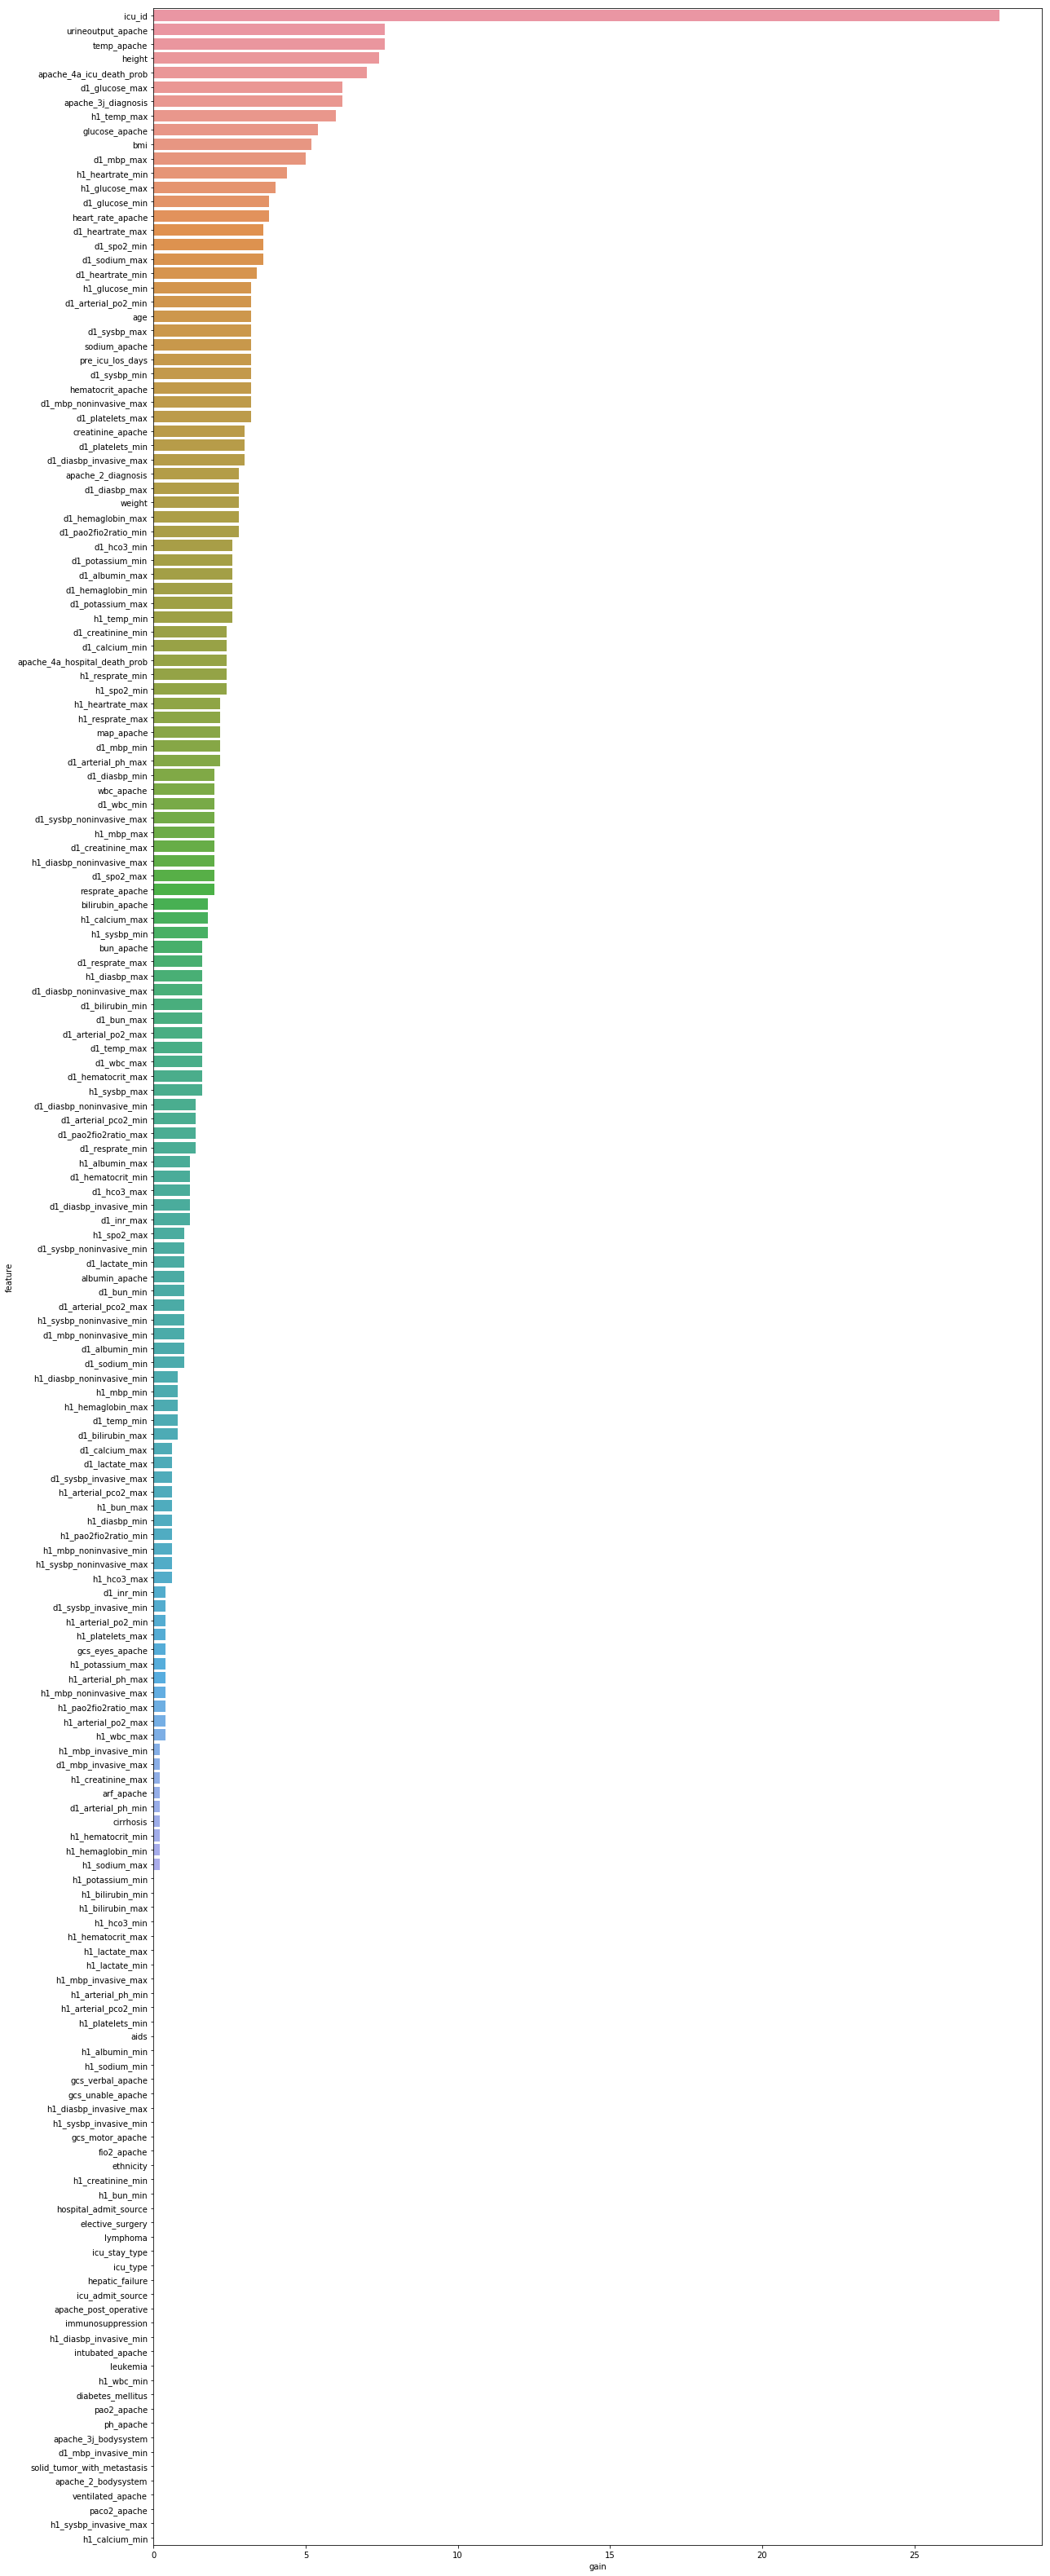

In [67]:
adversarial_features = adversarial_features[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features= adversarial_features.sort_values('gain', ascending=False)
plot_importances(adversarial_features)

icu_id 0 gain : 77


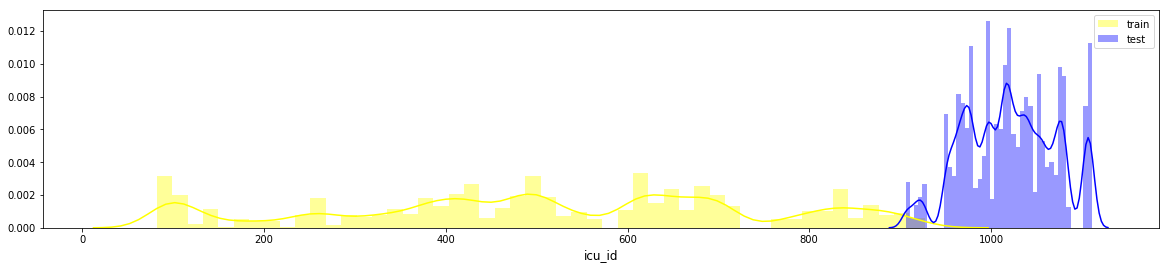

icu_id 1 gain : 31


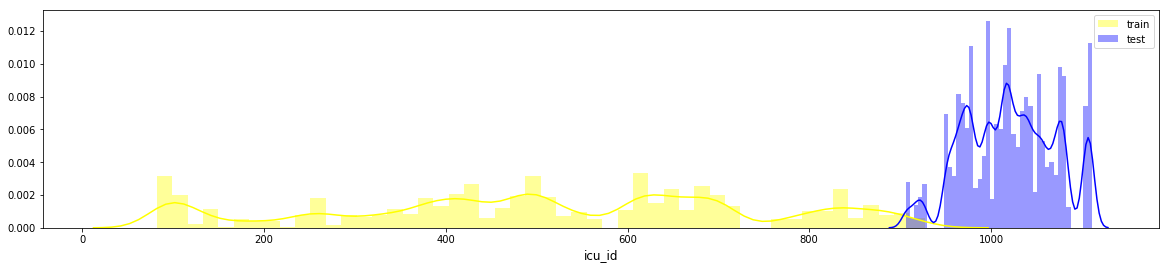

height 2 gain : 23


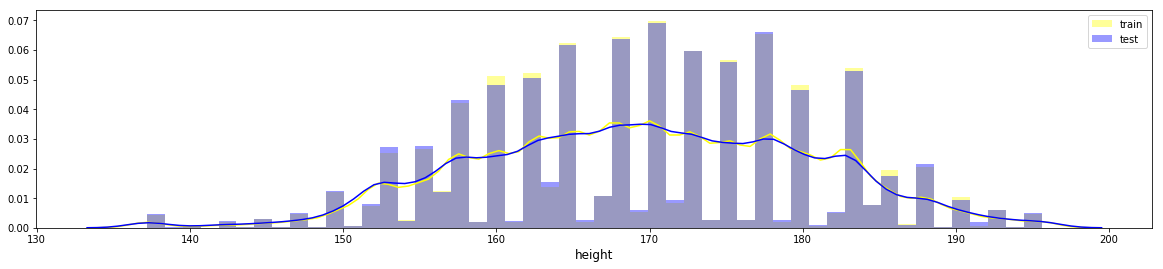

In [76]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 3:
            print(column,i,"gain :",row['gain'])
            df1      = train_new.copy()
            df2      = test_new.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

In [69]:
#remove icu id
adversarial_features2 = adversarial_validation(train_new, test_new, [ f for f in features if f not in ['icu_id'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.909556	valid_1's auc: 0.894505
[200]	training's auc: 0.936715	valid_1's auc: 0.908865
[300]	training's auc: 0.953398	valid_1's auc: 0.914272
[400]	training's auc: 0.965288	valid_1's auc: 0.917714
Early stopping, best iteration is:
[436]	training's auc: 0.968814	valid_1's auc: 0.918613
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.909868	valid_1's auc: 0.893359
[200]	training's auc: 0.936751	valid_1's auc: 0.906942
[300]	training's auc: 0.953389	valid_1's auc: 0.912187
[400]	training's auc: 0.965244	valid_1's auc: 0.915652
[500]	training's auc: 0.973823	valid_1's auc: 0.917623
[600]	training's auc: 0.980308	valid_1's auc: 0.919263
[700]	training's auc: 0.98506	valid_1's auc: 0.920445
[800]	training's auc: 0.989051	valid_1's auc: 0.921869
[900]	training's auc: 0.99167	valid_1's auc: 0.922779
Early stopping, best iteration is:
[897]	training's auc: 0.99

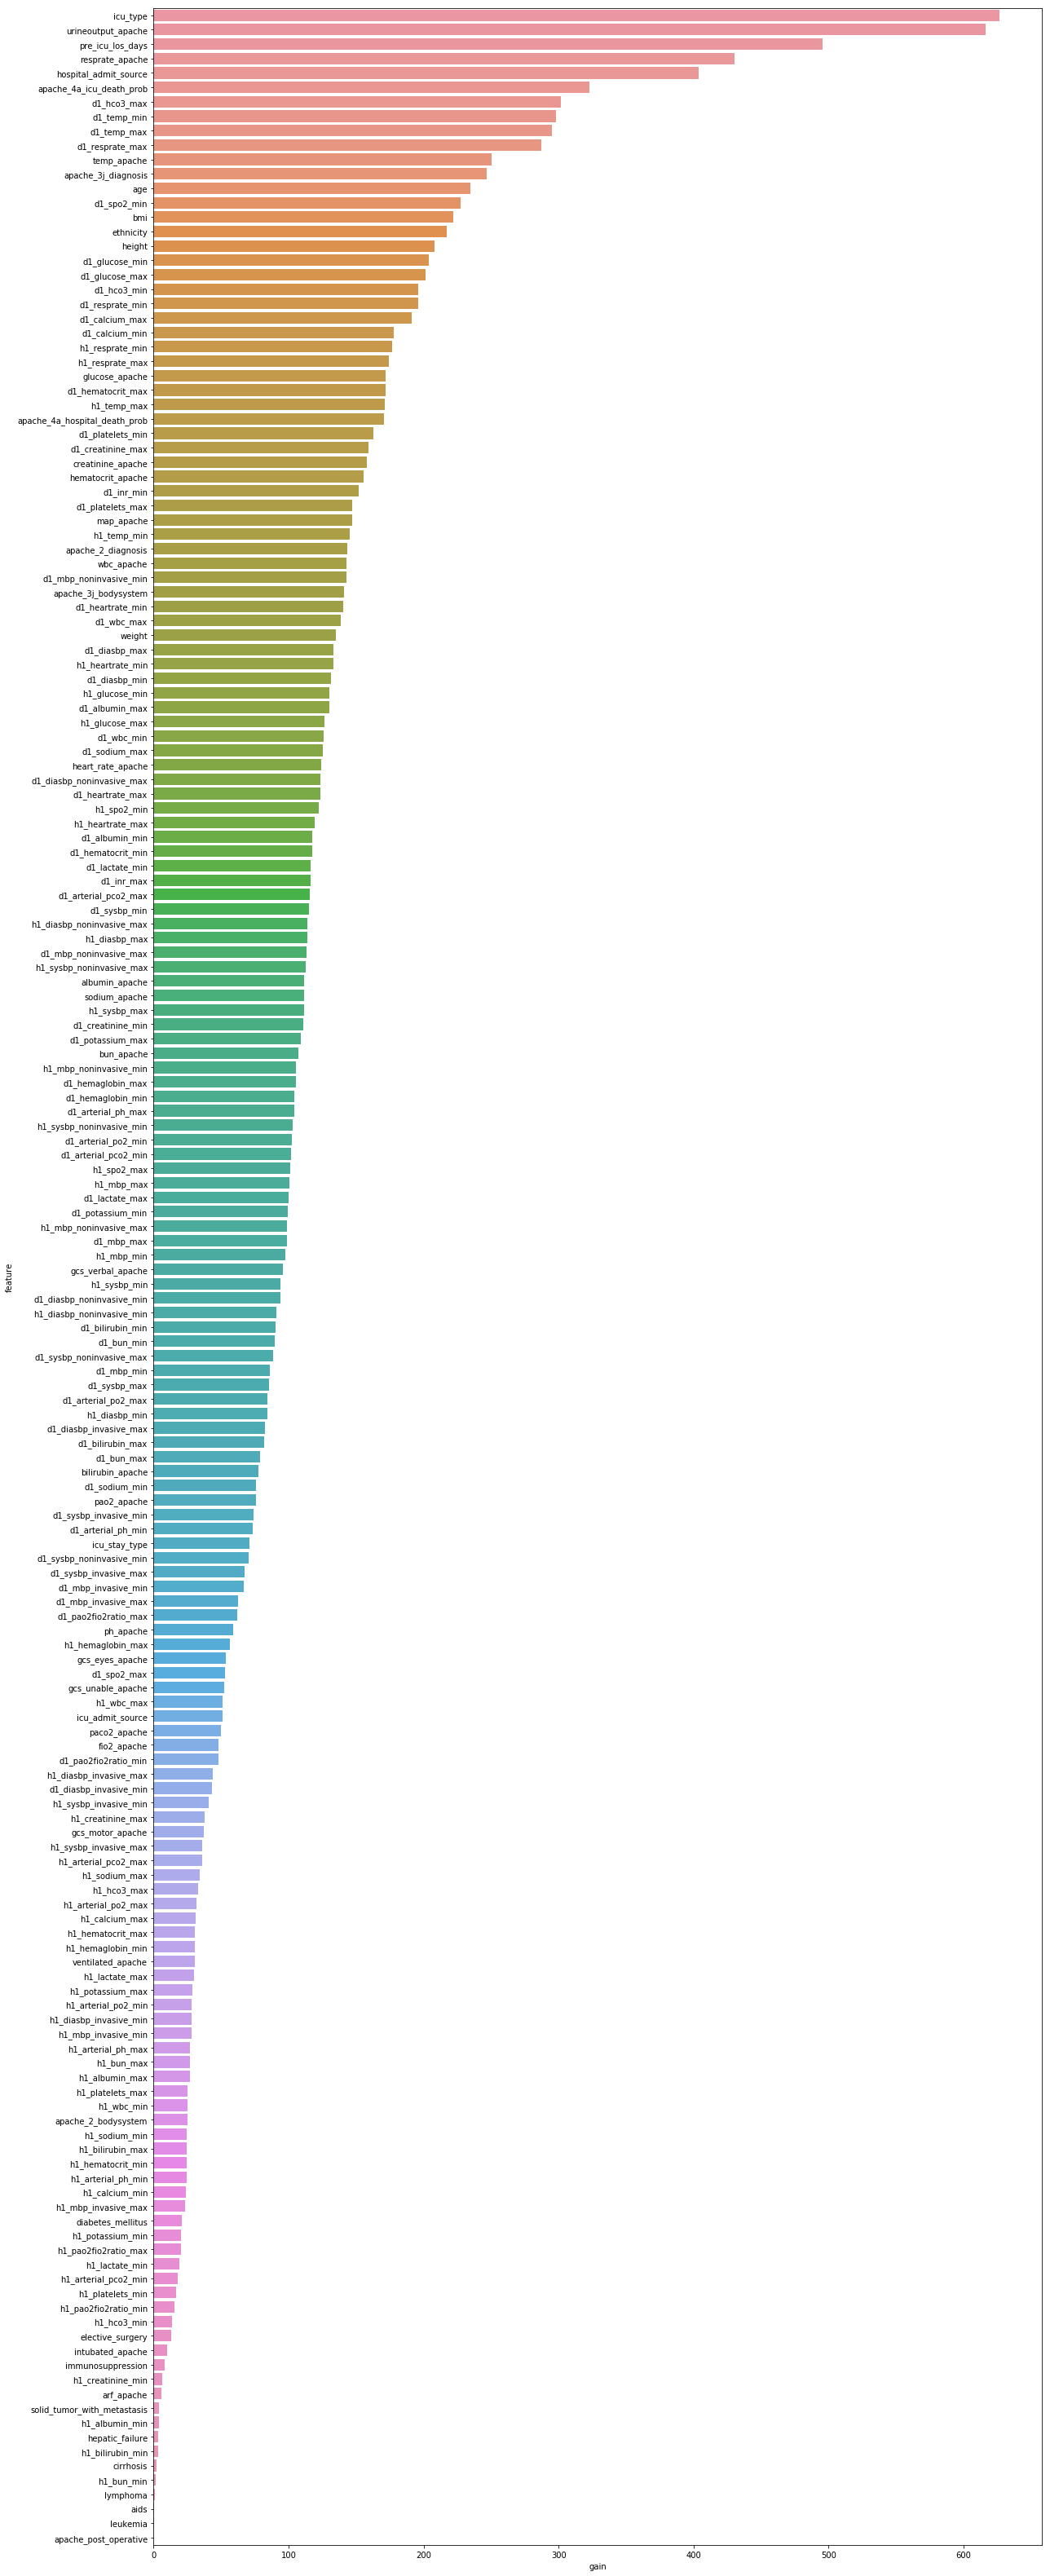

In [70]:
adversarial_features2 = adversarial_features2[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features2= adversarial_features2.sort_values('gain', ascending=False)
plot_importances(adversarial_features2)

icu_type 0 gain : 626.6


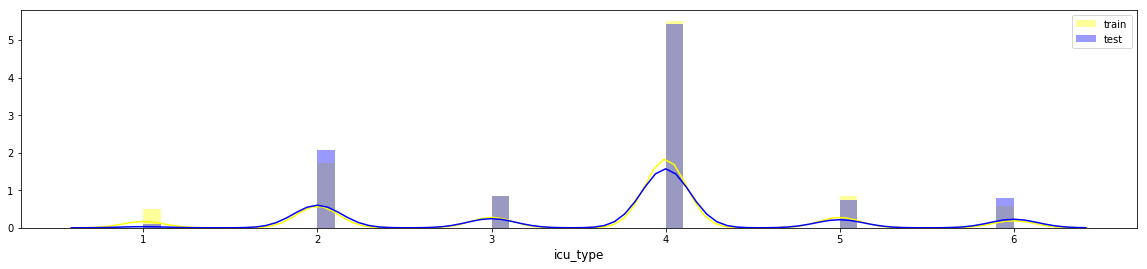

urineoutput_apache 1 gain : 616.4


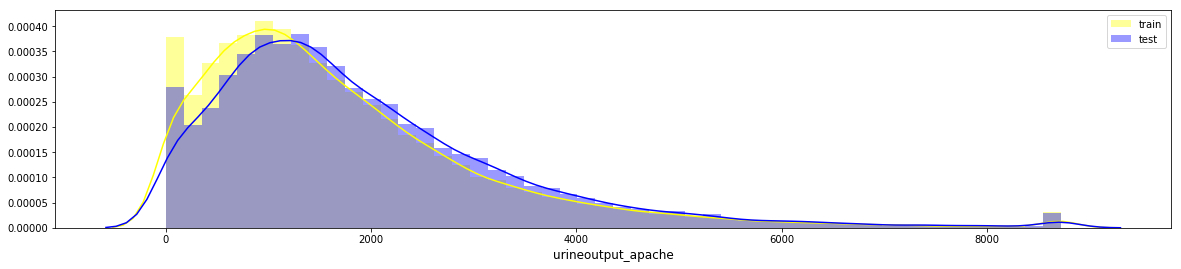

pre_icu_los_days 2 gain : 495.4


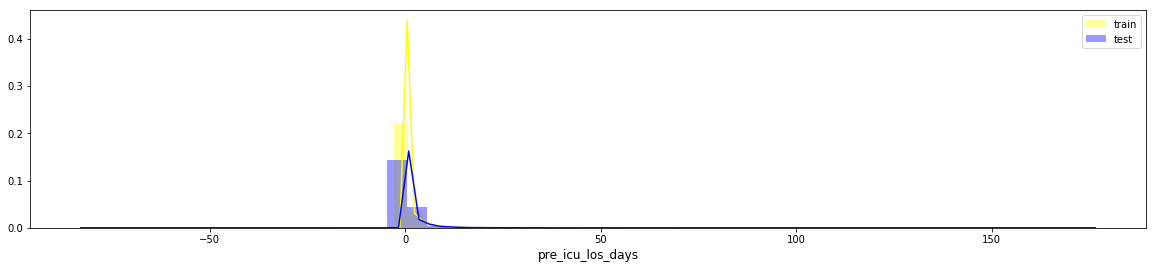

In [77]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features2.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 3:
            print(column,i,"gain :",row['gain'])
            df1      = train_new.copy()
            df2      = test_new.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

In [78]:
adversarial_features3 = adversarial_validation(train_new, test_new, [ f for f in features if f not in ['icu_id','urineoutput_apache'] ])

Fold 1
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.895951	valid_1's auc: 0.877468
[200]	training's auc: 0.927184	valid_1's auc: 0.892736
[300]	training's auc: 0.945958	valid_1's auc: 0.898236
[400]	training's auc: 0.959761	valid_1's auc: 0.902932
[500]	training's auc: 0.969802	valid_1's auc: 0.905926
[600]	training's auc: 0.976989	valid_1's auc: 0.907869
[700]	training's auc: 0.983143	valid_1's auc: 0.910682
[800]	training's auc: 0.98723	valid_1's auc: 0.912321
Early stopping, best iteration is:
[824]	training's auc: 0.988082	valid_1's auc: 0.912778
Fold 2
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.897006	valid_1's auc: 0.879697
[200]	training's auc: 0.928038	valid_1's auc: 0.894491
[300]	training's auc: 0.947389	valid_1's auc: 0.899571
[400]	training's auc: 0.960474	valid_1's auc: 0.902705
[500]	training's auc: 0.970397	valid_1's auc: 0.905311
[600]	training's auc: 0.977645	valid_1's auc: 0.907729
Early

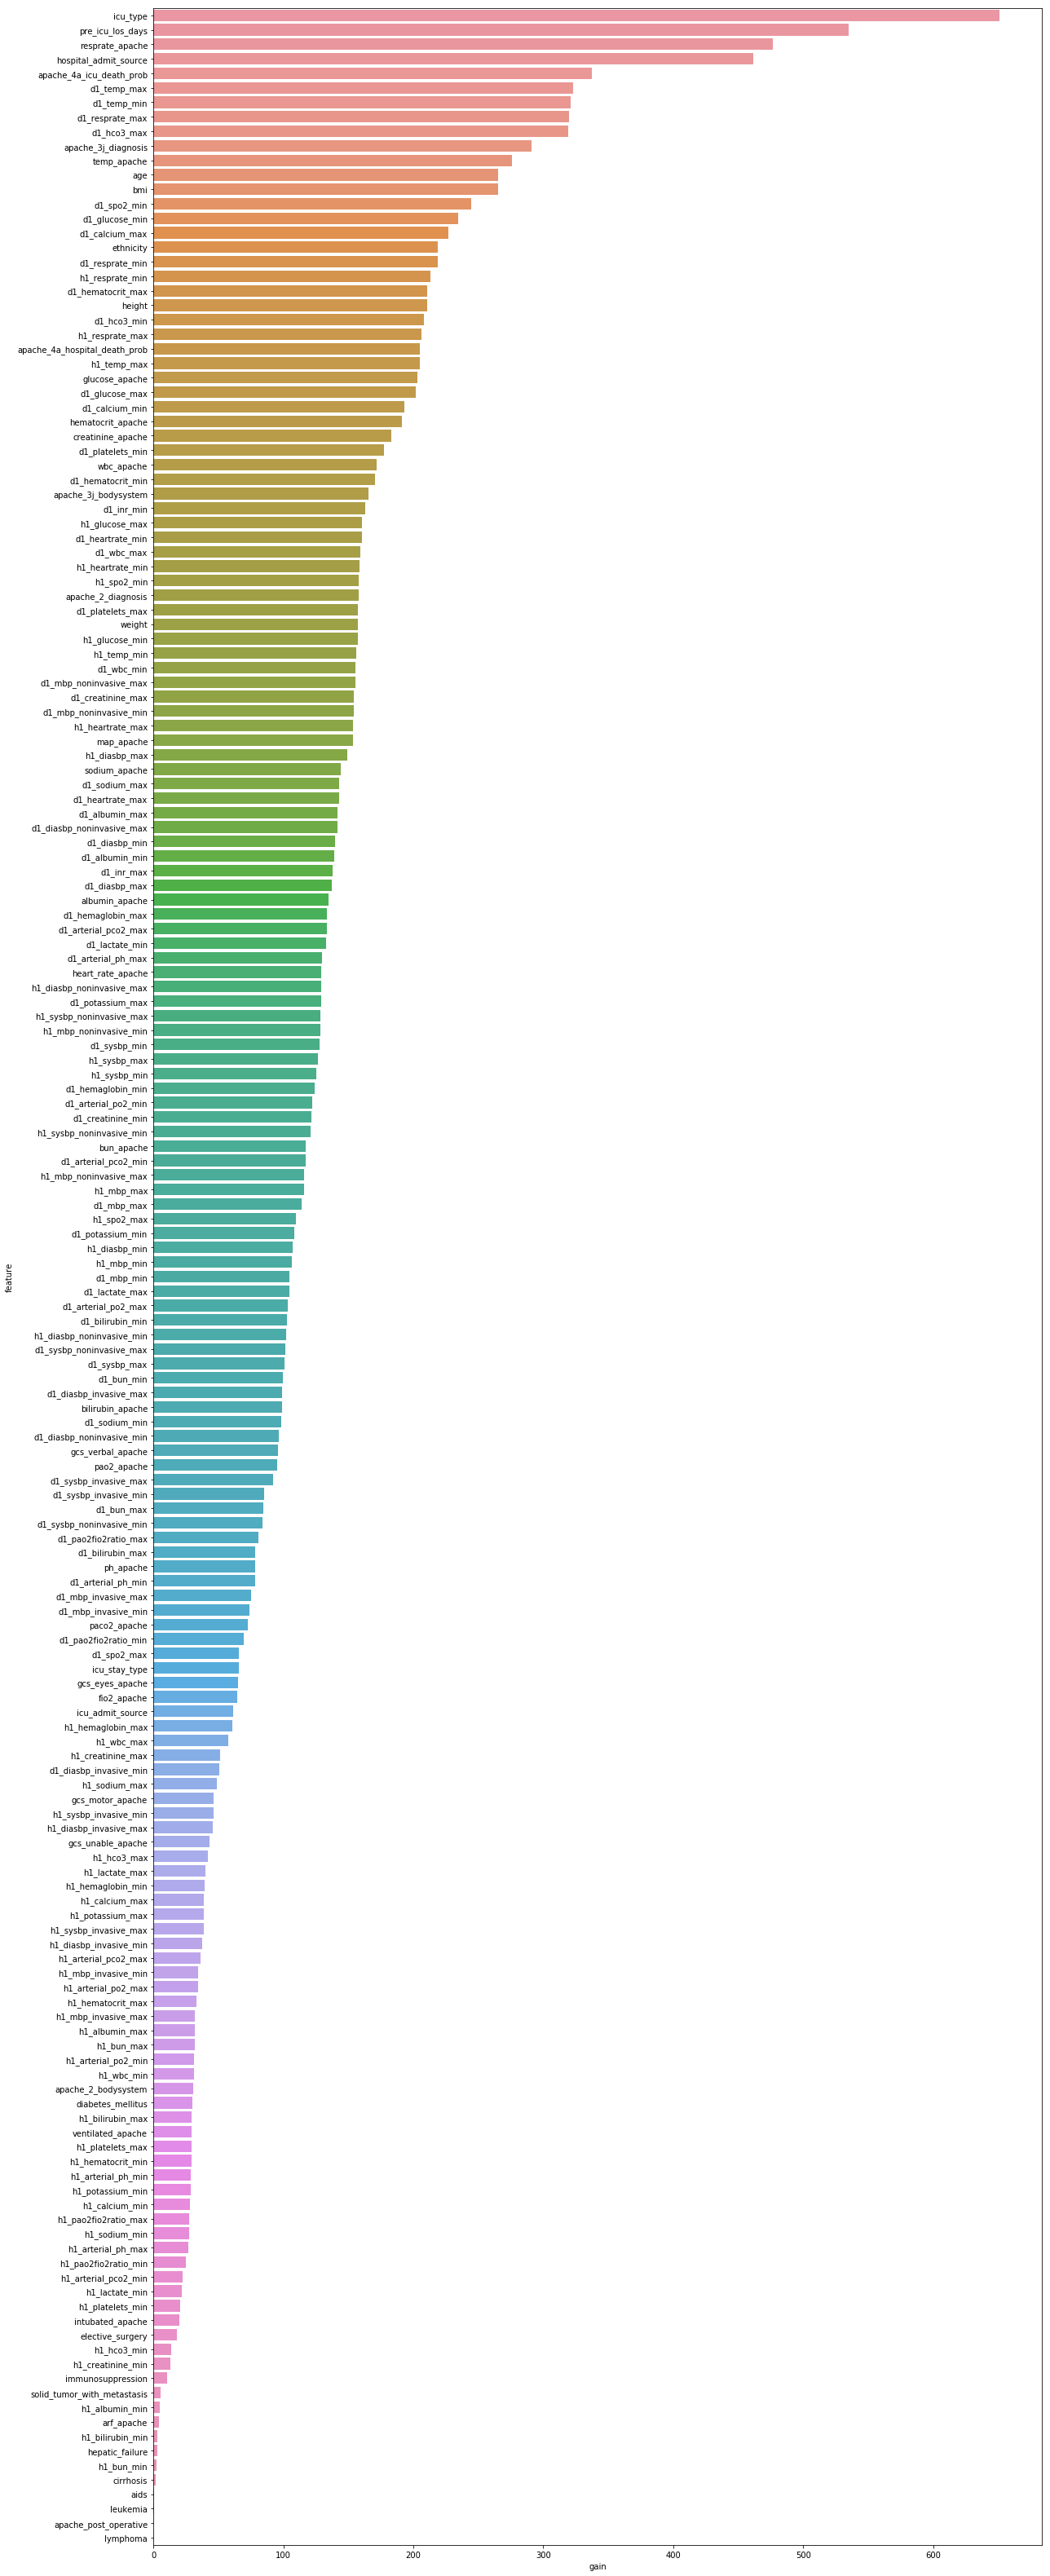

In [79]:
adversarial_features3 = adversarial_features3[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features3= adversarial_features3.sort_values('gain', ascending=False)
plot_importances(adversarial_features3)

icu_type 0 gain : 651.2


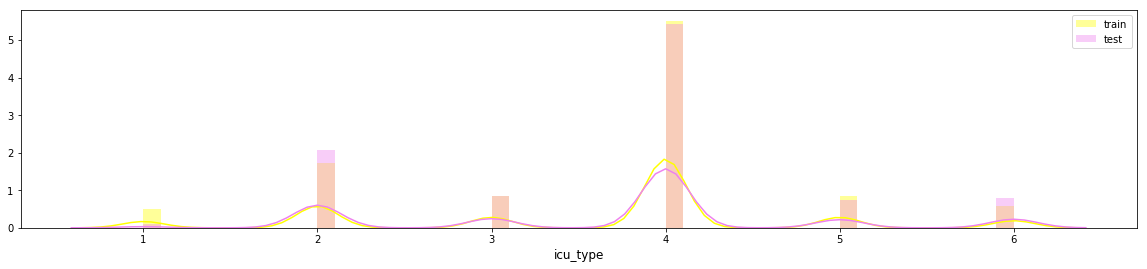

pre_icu_los_days 1 gain : 535.0


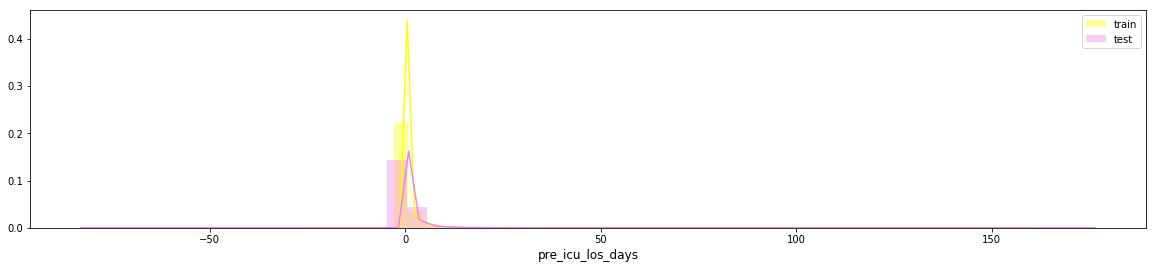

resprate_apache 2 gain : 476.4


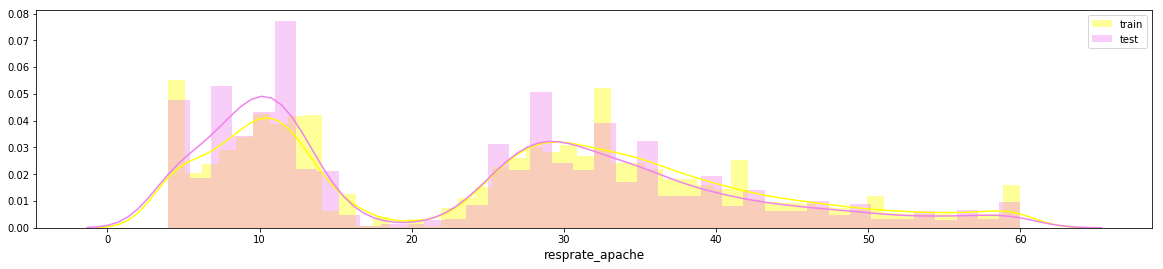

hospital_admit_source 3 gain : 461.4


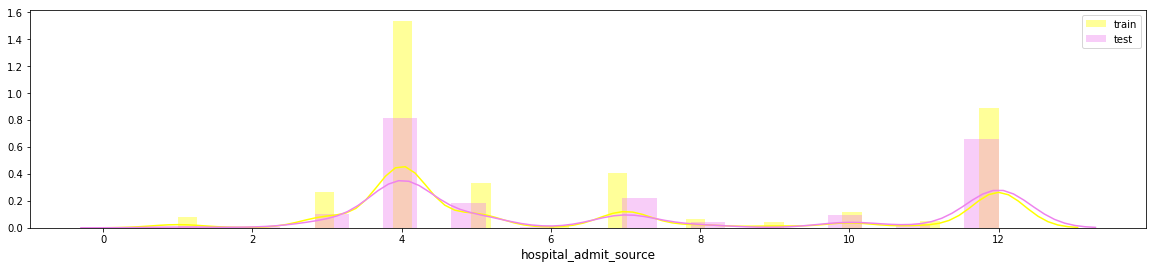

apache_4a_icu_death_prob 4 gain : 337.6


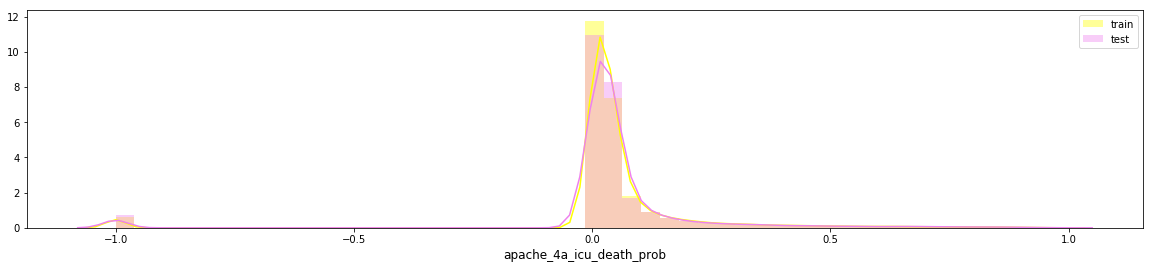

In [80]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features3.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 5:
            print(column,i,"gain :",row['gain'])
            df1      = train_new.copy()
            df2      = test_new.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

### Until here, all the features follow similar distributions in both test and train set. Lets move on!

In [82]:
# dataframes after removing adversarial validated features
train_new_2=train_new.drop(['icu_id','urineoutput_apache','icu_type'],axis=1)
test_new_2=test_new.drop(['icu_id','urineoutput_apache','icu_type'],axis=1)

In [85]:
categorical2=train_new_2.select_dtypes(include='O').columns.values.tolist()
train_new_columns2 =train_new_2.columns.tolist()
categorical_index2 = [train_new_columns2.index(x) for x in categorical2]

## Retrain model and check the AUC

In [87]:
roc_auc_new = list()
feature_importances_new = pd.DataFrame()
feature_importances_new['feature'] = train_new_2.columns
pred_on_test_new = np.zeros(test_new_2.shape[0])
for index, (train_index, valid_index) in enumerate(kf.split(X=train_new_2,y=y)):
    print(f"FOLD {index+1}")
    num_round = 7000
    X_train_fold, y_train_fold = train_new_2.iloc[train_index], y.iloc[train_index]
    X_valid_fold, y_valid_fold = train_new_2.iloc[valid_index], y.iloc[valid_index]

    dtrain = lightgbm.Dataset(X_train_fold, label=y_train_fold)
    dvalid = lightgbm.Dataset(X_valid_fold, label=y_valid_fold,reference=dtrain)

    lgb = lightgbm.train(param,dtrain,num_round,valid_sets=dvalid,early_stopping_rounds=100,
                         verbose_eval=200,categorical_feature=categorical_index2)

    feature_importances_new[f'fold_{index + 1}'] = lgb.feature_importance()

    y_valid_pred = (lgb.predict(X_valid_fold,num_iteration=lgb.best_iteration))
    pred_on_test_new += (lgb.predict(test_new_2,num_iteration=lgb.best_iteration)) / kf.n_splits

    # winsorization
    y_valid_pred = np.clip(a=y_valid_pred, a_min=0, a_max=1)
    pred_on_test_new = np.clip(a=pred_on_test_new, a_min=0, a_max=1)

    print(f"FOLD {index+1}: ROC_AUC  => {np.round(roc_auc_score(y_true=y_valid_fold, y_score=y_valid_pred),5)}")
    roc_auc_new.append(roc_auc_score(y_true=y_valid_fold, y_score=y_valid_pred)/kf.n_splits)
    
print(f"Mean roc_auc for {kf.n_splits} folds: {np.round(sum(roc_auc),5)}")

FOLD 1
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.891558
[400]	valid_0's auc: 0.899201
[600]	valid_0's auc: 0.90319
[800]	valid_0's auc: 0.905437
[1000]	valid_0's auc: 0.90697
[1200]	valid_0's auc: 0.908228
[1400]	valid_0's auc: 0.90904
[1600]	valid_0's auc: 0.909602
[1800]	valid_0's auc: 0.910079
[2000]	valid_0's auc: 0.910463
[2200]	valid_0's auc: 0.910712
[2400]	valid_0's auc: 0.910932
[2600]	valid_0's auc: 0.911053
[2800]	valid_0's auc: 0.91123
Early stopping, best iteration is:
[2794]	valid_0's auc: 0.911233
FOLD 1: ROC_AUC  => 0.91123
FOLD 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.881372
[400]	valid_0's auc: 0.888861
[600]	valid_0's auc: 0.892386
[800]	valid_0's auc: 0.894575
[1000]	valid_0's auc: 0.89611
[1200]	valid_0's auc: 0.897086
[1400]	valid_0's auc: 0.897903
[1600]	valid_0's auc: 0.898468
[1800]	valid_0's auc: 0.898895
[2000]	valid_0's auc: 0.899226
[2200]	valid_0's auc: 0.899491
[2400]

# Global interpretation of the important features

In [102]:
features_new=[col for col in train_new_2.columns]

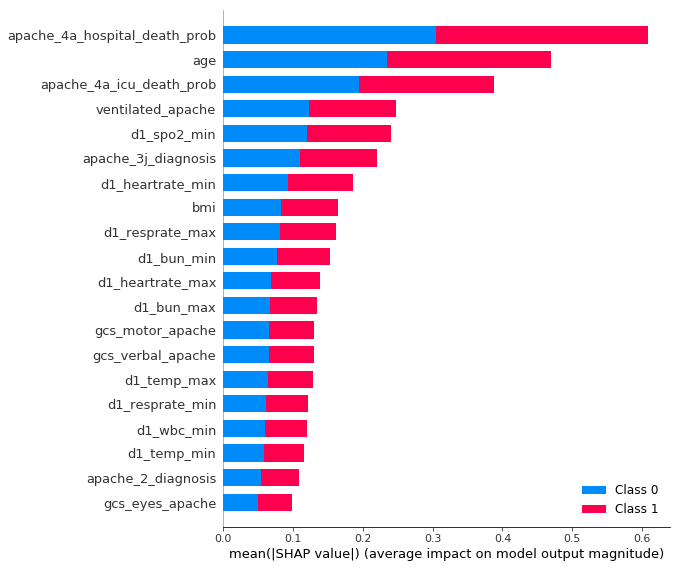

In [103]:
explainer   =  shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(train_new_2[features_new].iloc[:1000,:])
shap.summary_plot(shap_values, train_new_2[features_new].iloc[:1000,:])
#The top variables contribute more to the model than the bottom ones.
# Feature importance: Variables are ranked in descending order.
# Value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
# Correlation:  The “high” comes from the red color, and the “positive” impact is shown on the X-axis.


In [90]:
final_labels=pd.DataFrame(pred_on_test_new,columns=['hospital_death'])

### Final labels in csv

In [92]:
final_labels.to_csv("Lightgbm_results.csv")